# GeoCluster Demo

This notebook contains a demo of the GeoCluster algorithm for a dataset of **1000 squares** (with rotation) in 2D space.

The metric used is `L_inf`, where the function is adjusted to calculate the `L_inf` distance between a square object and a point.

## Load libraries and data

In [2]:
import torch
from src.k_tree import Ktree
from src.k_tree_ls import Ktree as Ktree_ls
from src.utils.objects.squares import loadData as loadSquares
from src.metrics import Linf_simple
from src.utils import plot_tools as pt
from src.utils import accuracy as acc

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Initialise k-tree with training parameters

In order to create the hierarchical clustering tree structure, we initialise a `Ktree` object which takes as parameters the training arguments for the *Clustering* and *Critic* models, as well as the arguments for the UN sampler.

In [ ]:
dim = 2  # space dimension

k = 3  # number of centroids to generate in the Clustering model
clustering_args = {
    "epochs": 30,  # number of epochs
    "pre_processing": 10,
    "number_of_centroids": k,  # number of centroids to generate in the Clustering model
    "dimension": dim,  # space dimension
}
n = 30
un_args = {
    "N": n,  # number of points to sample
    "M": n**2 - 1,  # number of points to return
    "epsilon": 0.15,  # the epsilon ball
}
critic_args = {
    "optimizer_lr": 5e-3,  # optimiser learning rate
    "epochs": 1000,  # number of epochs
    "width": 200,  # width of the model's linear layers
    "depth": 5,  # depth of the model's linear layers
}

threshold = 300  # if a tree node has data less than the threshold, stop division

# Initialise the k-tree structure.
ktree = Ktree_ls(
    threshold, data2d, Linf_simple, clustering_args, un_args, critic_args, device, dim
)

In [11]:
# create 3D line_segments
# n = 10000
# lim = 50000
# var = 500
n = 100
lim = 500
var = 100

bbox = [0, lim, 0, lim, 0, lim]
length_size = [0.1, var]
theta_size = [0, 180]
phi_size = [0, 360]


def create_line_segments_3d(n, bbox, length_size, theta_size, phi_size):
    line_segments = torch.zeros((n, 6))  # ls = [x0,y0,z0, l, theta, phi]
    for i in range(n):
        x0 = torch.rand(1) * (bbox[1] - bbox[0]) + bbox[0]
        y0 = torch.rand(1) * (bbox[3] - bbox[2]) + bbox[2]
        z0 = torch.rand(1) * (bbox[5] - bbox[4]) + bbox[4]
        l = torch.rand(1) * (length_size[1] - length_size[0]) + length_size[0]
        theta = torch.rand(1) * (theta_size[1] - theta_size[0]) + theta_size[0]
        theta = torch.deg2rad(theta)
        phi = torch.rand(1) * (phi_size[1] - phi_size[0]) + phi_size[0]
        phi = torch.deg2rad(phi)
        line_segments[i, :] = torch.cat([x0, y0, z0, l, theta, phi])
    return line_segments


data = create_line_segments_3d(n, bbox, length_size, theta_size, phi_size)
# make the points
data_points = torch.zeros((n, 6))
for i in range(n):
    data_points[i, 0] = data[i, 0]
    data_points[i, 1] = data[i, 1]
    data_points[i, 2] = data[i, 2]
    data_points[i, 3] = data[i, 0] + data[i, 3] * torch.sin(data[i, 4]) * torch.cos(
        data[i, 5]
    )
    data_points[i, 4] = data[i, 1] + data[i, 3] * torch.sin(data[i, 4]) * torch.sin(
        data[i, 5]
    )
    data_points[i, 5] = data[i, 2] + data[i, 3] * torch.cos(data[i, 4])
data3d = data

In [ ]:
# lets plot them as 3d lines using matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
for i in range(n):
    ax.plot(
        [data_points[i, 0], data_points[i, 3]],
        [data_points[i, 1], data_points[i, 4]],
        [data_points[i, 2], data_points[i, 5]],
    )
ax.set_xlim([bbox[0], bbox[1]])
ax.set_ylim([bbox[2], bbox[3]])
ax.set_zlim([bbox[4], bbox[5]])
plt.show()

In [ ]:
import torch


# check if 2 linesegments intersect


def check_ls_intersection_2d(ls1, ls2):

    # ls are of the form [x0,y0,l,theta]

    x1 = ls1[0]

    y1 = ls1[1]
    l1 = ls1[2]

    theta1 = ls1[3]

    x2 = ls2[0]

    y2 = ls2[1]
    l2 = ls2[2]

    theta2 = ls2[3]

    # check if the lines are parallel

    if torch.abs(theta1 - theta2) < 1e-6:

        return False

    # get their distance

Creating 10000 line segments
x0 shape: torch.Size([10000])
l shape: torch.Size([10000])
theta shape: torch.Size([10000])
Data shape: torch.Size([10000, 4])
Data points shape: torch.Size([10000, 4])


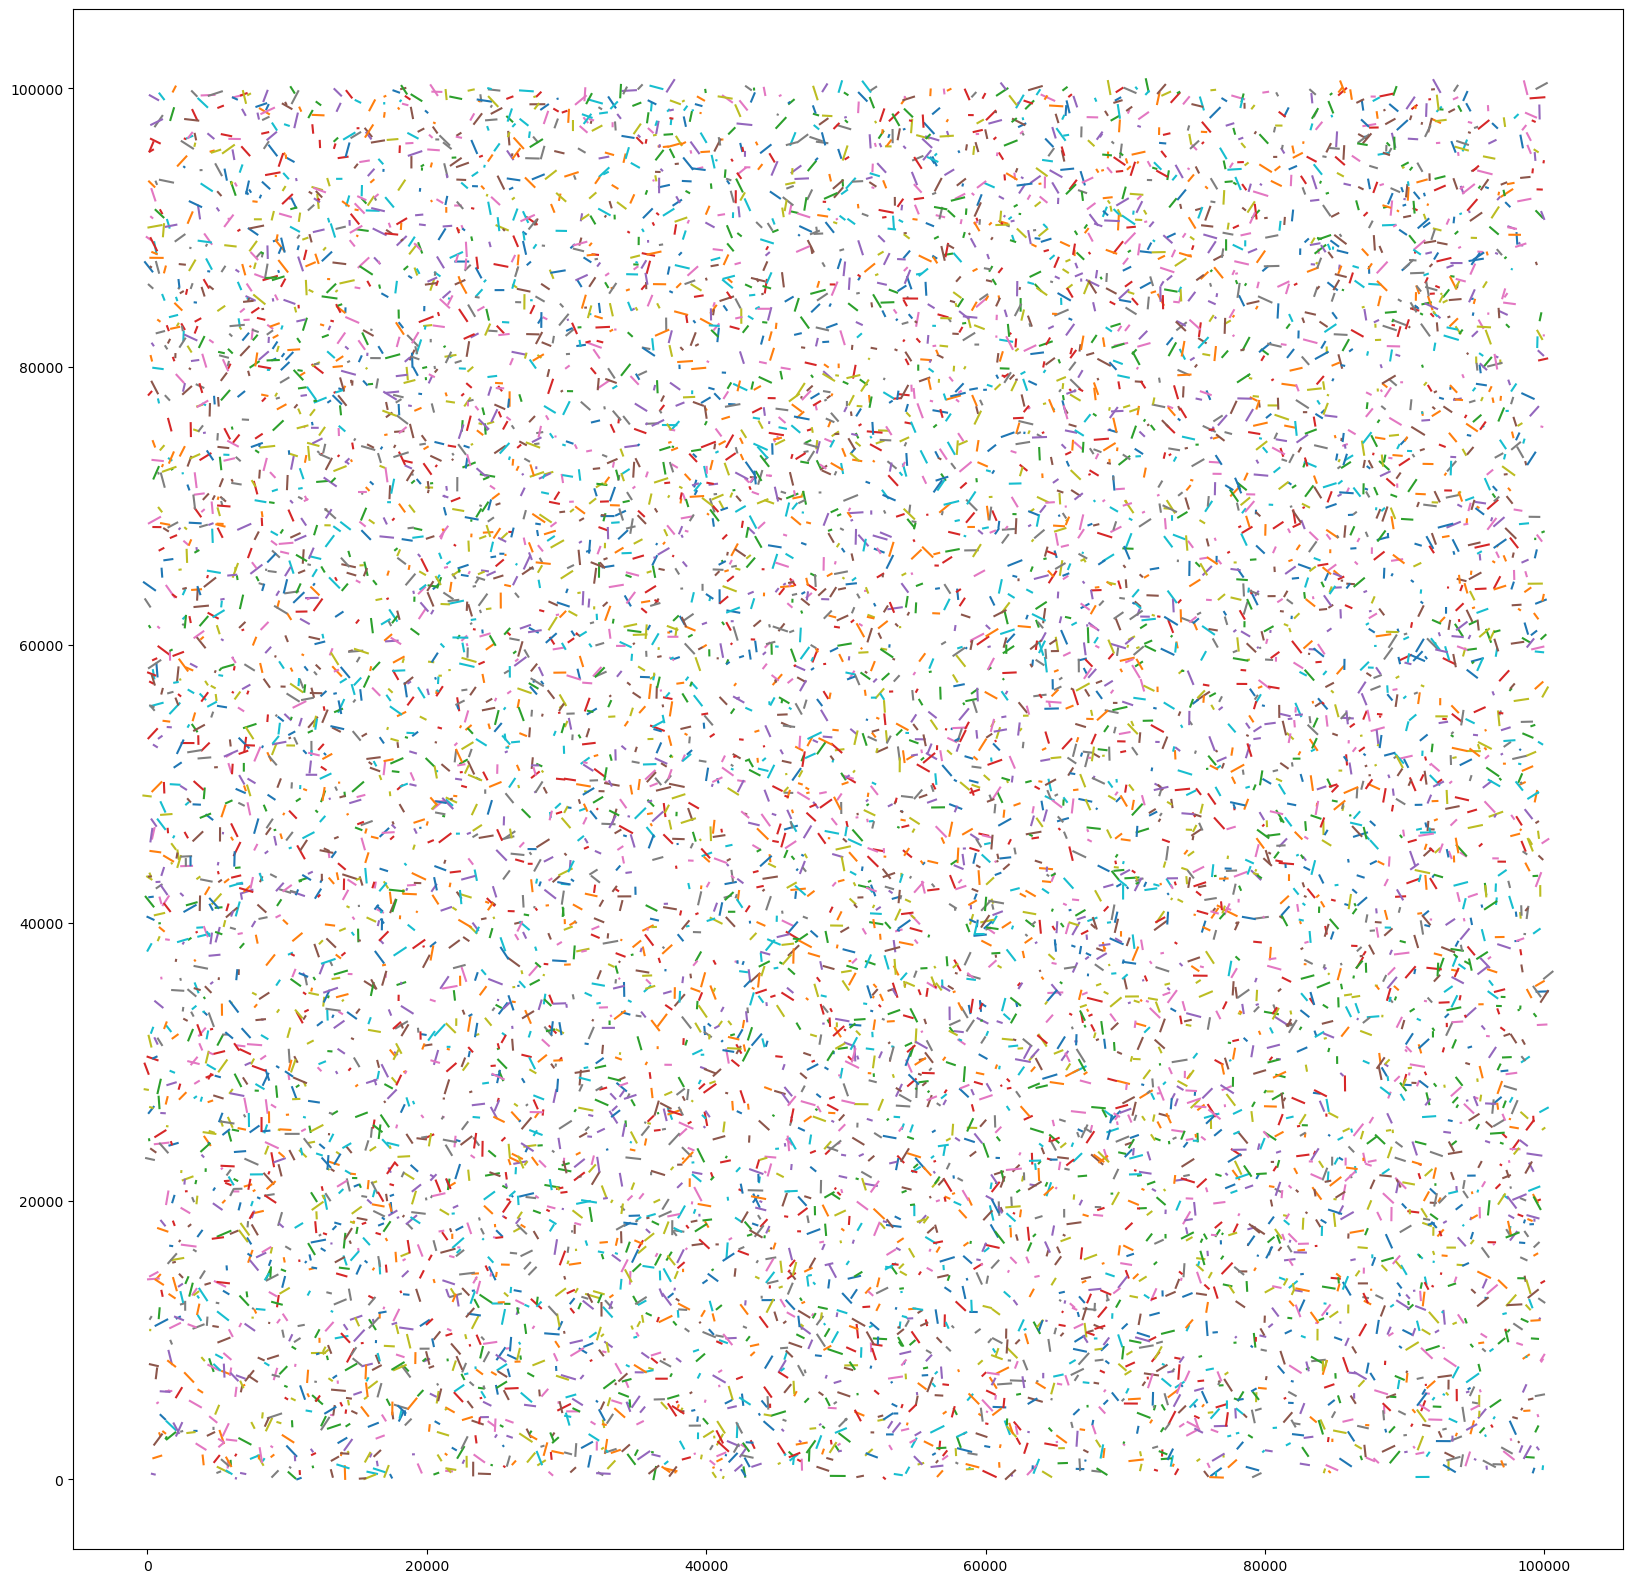

In [24]:
# lets generate #n line segments inside a bbox
n = 10000
bbox_lim = 1e5
bbox = [0, bbox_lim, 0, bbox_lim]  # bbox = [xmin,xmax,ymin,ymax
length_size = [0.1, 1000]  # length of the line segment
theta_size = [0, 180]  # angle of the line segment


# line segments will be [x0,y0,l,theta]
# sample x0,y0 inside bbox
def create_line_segments(n, bbox, length_size, theta_size):
    print(f"Creating {n} line segments")
    x0 = torch.rand(n) * (bbox[1] - bbox[0]) + bbox[0]
    y0 = torch.rand(n) * (bbox[3] - bbox[2]) + bbox[2]
    print(f"x0 shape: {x0.shape}")
    # sample l inside length_size
    l = torch.rand(n) * (length_size[1] - length_size[0]) + length_size[0]
    print(f"l shape: {l.shape}")
    # sample theta inside theta_size
    theta_size = torch.rand(n) * (theta_size[1] - theta_size[0]) + theta_size[0]
    print(f"theta shape: {theta_size.shape}")
    theta_size = torch.deg2rad(theta_size)
    return torch.stack([x0, y0, l, theta_size], dim=1)


data = create_line_segments(n, bbox, length_size, theta_size)
print(f"Data shape: {data.shape}")
# first make data from embedding to datapoints
data_points = torch.zeros(n, 4)
data_points[:, 0] = data[:, 0]
data_points[:, 1] = data[:, 1]
data_points[:, 2] = data[:, 0] + data[:, 2] * torch.cos(data[:, 3])
data_points[:, 3] = data[:, 1] + data[:, 2] * torch.sin(data[:, 3])
print(f"Data points shape: {data_points.shape}")
data2d = data

import matplotlib.pyplot as plt

# make plot size big
plt.figure(figsize=(20, 20))
plt.plot([data_points[:, 0], data_points[:, 2]], [data_points[:, 1], data_points[:, 3]])
plt.axis("equal")
plt.show()

In [ ]:
x = torch.rand(100, 4)
a, b, c, d = (
    x[:, 0],
    x[:, 1],
    x[:, 2],
    x[:, 3],
)

In [ ]:
import torch


def compute_distances(segments, centroid):
    print(segments.shape)
    print(type(segments))
    print(segments[0])
    # Unpack the centroid coordinates
    cx, cy = centroid
    # Unpack the segments
    x0s, y0s, lengths, thetas = (
        segments[:, 0],
        segments[:, 1],
        segments[:, 2],
        segments[:, 3],
    )
    # Calculate the endpoints of the segments
    x1s = x0s + lengths * torch.cos(thetas)
    y1s = y0s + lengths * torch.sin(thetas)
    # Vector from (x0, y0) to centroid
    vec_p0_c = torch.stack([cx - x0s, cy - y0s], dim=1)
    # Direction vector of the segments
    vec_p0_p1 = torch.stack([x1s - x0s, y1s - y0s], dim=1)
    # Projection scalar of vec_p0_c onto vec_p0_p1
    dot_products = torch.sum(vec_p0_c * vec_p0_p1, dim=1)
    segment_lengths_squared = torch.sum(vec_p0_p1 * vec_p0_p1, dim=1)
    projection_scalars = dot_products / segment_lengths_squared
    # Clamp the projection_scalars to lie within the segment
    projection_scalars = torch.clamp(projection_scalars, min=0, max=1)
    # Calculate the nearest points on the segments to the centroid
    nearest_xs = x0s + projection_scalars * (x1s - x0s)
    nearest_ys = y0s + projection_scalars * (y1s - y0s)
    # Distance from nearest points on the segments to the centroid
    distances = torch.sqrt((nearest_xs - cx) ** 2 + (nearest_ys - cy) ** 2)

    return distances


segments = data
centroid = torch.tensor([2.0, 2.0])  # [x0, y0]

distances = compute_distances(segments, centroid)
print(distances.shape)

In [ ]:
import torch


def compute_distances_2d(segments, centroid):
    # Unpack the centroid coordinates
    cx, cy = centroid
    # Unpack the segments
    x0s, y0s, lengths, thetas = (
        segments[:, 0],
        segments[:, 1],
        segments[:, 2],
        segments[:, 3],
    )
    # Calculate the endpoints of the segments
    x1s = x0s + lengths * torch.cos(thetas)
    y1s = y0s + lengths * torch.sin(thetas)
    # Vector from (x0, y0) to centroid
    vec_p0_c = torch.stack([cx - x0s, cy - y0s], dim=1)
    # Direction vector of the segments
    vec_p0_p1 = torch.stack([x1s - x0s, y1s - y0s], dim=1)
    # Projection scalar of vec_p0_c onto vec_p0_p1
    dot_products = torch.sum(vec_p0_c * vec_p0_p1, dim=1)
    segment_lengths_squared = torch.sum(vec_p0_p1 * vec_p0_p1, dim=1)
    projection_scalars = dot_products / segment_lengths_squared
    # Clamp the projection_scalars to lie within the segment
    projection_scalars = torch.clamp(projection_scalars, min=0, max=1)
    # Calculate the nearest points on the segments to the centroid
    nearest_xs = x0s + projection_scalars * (x1s - x0s)
    nearest_ys = y0s + projection_scalars * (y1s - y0s)
    # Distance from nearest points on the segments to the centroid
    distances = torch.sqrt((nearest_xs - cx) ** 2 + (nearest_ys - cy) ** 2)

    return distances


def compute_distances_3d(segments, centroid):
    # Unpack the centroid coordinates
    cx, cy, cz = centroid
    # Unpack the segments
    x0s, y0s, z0s, lengths, thetas, phis = (
        segments[:, 0],
        segments[:, 1],
        segments[:, 2],
        segments[:, 3],
        segments[:, 4],
        segments[:, 5],
    )
    # Calculate the endpoints of the segments
    x1s = x0s + lengths * torch.sin(thetas) * torch.cos(phis)
    y1s = y0s + lengths * torch.sin(thetas) * torch.sin(phis)
    z1s = z0s + lengths * torch.cos(thetas)
    # Vector from (x0, y0) to centroid
    vec_p0_c = torch.stack([cx - x0s, cy - y0s, cz - z0s], dim=1)
    # Direction vector of the segments
    vec_p0_p1 = torch.stack([x1s - x0s, y1s - y0s, z1s - z0s], dim=1)
    # Projection scalar of vec_p0_c onto vec_p0_p1
    dot_products = torch.sum(vec_p0_c * vec_p0_p1, dim=1)
    segment_lengths_squared = torch.sum(vec_p0_p1 * vec_p0_p1, dim=1)
    projection_scalars = dot_products / segment_lengths_squared
    # Clamp the projection_scalars to lie within the segment
    projection_scalars = torch.clamp(projection_scalars, min=0, max=1)
    # Calculate the nearest points on the segments to the centroid
    nearest_xs = x0s + projection_scalars * (x1s - x0s)
    nearest_ys = y0s + projection_scalars * (y1s - y0s)
    nearest_zs = z0s + projection_scalars * (z1s - z0s)
    # Distance from nearest points on the segments to the centroid
    distances = torch.sqrt(
        (nearest_xs - cx) ** 2 + (nearest_ys - cy) ** 2 + (nearest_zs - cz) ** 2
    )

    return distances


def get_dist_matrix(data, centroids, dist_function):
    # init.
    dist_matrix = torch.zeros(data.shape[0], centroids.shape[0])
    for i in range(centroids.shape[0]):
        dist_matrix[:, i] = dist_function(data, centroids[i])
    return dist_matrix


def kmeans_pp_greedy(
    data,
    n_clusters,
    dist_function,
    dim,
    random_state=None,
    n_trials=None,
):
    # check parameters
    if type(data) is not torch.Tensor:
        data = torch.tensor(data)
    n_samples, n_features = data.shape
    if n_clusters > n_samples:
        raise ValueError(
            "n_clusters should be smaller or equal to the number of centroids"
        )
    if type(n_clusters) is not torch.Tensor:
        n_clusters = torch.tensor(n_clusters)
    if n_trials is None:
        n_trials = 2 + int(torch.log(n_clusters))
    # set random state
    if random_state is not None:
        torch.manual_seed(random_state)
    # initialize centroids
    centroids = torch.zeros(n_clusters, dim)
    # choose first centroid
    first_centroid_idx = torch.randint(n_samples, (1,))
    # print(f"First centroid index: {first_centroid_idx}")
    data_oi = data[first_centroid_idx]
    if dim == 2:
        x0, y0, l, theta = data_oi[0]
        centroids[0] = torch.tensor([x0, y0])
        centroids[0] += torch.tensor([0.5 * l * torch.cos(theta), l * torch.sin(theta)])
    elif dim == 3:
        x0, y0, z0, l, theta, phi = data_oi[0]
        centroids[0] = torch.tensor([x0, y0, z0])
        centroids[0] += torch.tensor(
            [
                0.5 * l * torch.sin(theta) * torch.cos(phi),
                0.5 * l * torch.sin(theta) * torch.sin(phi),
                0.5 * l * torch.cos(theta),
            ]
        )
    else:
        raise ValueError("dim should be 2 or 3")

    # create a vector of minus ones of shape (n_samples,)
    indices = -torch.ones(n_samples)
    # init dist matrix
    print(f"Data shape: {data.shape}")
    print(f"Centroids shape: {centroids.shape}")
    print(f"Dist function: {dist_function}")
    dist_matrix = get_dist_matrix(data, centroids[:1], dist_function)

    for i in range(1, n_clusters):
        # print("=" * 20)
        # print("=" * 20)
        # choose the next centroid
        freq = torch.zeros(n_trials)
        for _ in range(n_trials):
            # choose a centroid with probability proportional to the distance
            # to the closest centroid
            dists = torch.min(dist_matrix, dim=1).values
            probs = dists / torch.sum(dists)
            # print(f"Probs : {probs}")
            next_centroid_idx = torch.multinomial(probs, 1)
            # print(f"Next centroid index: {next_centroid_idx}")
            # update best_dist
            freq[_] = next_centroid_idx
        # pick randomly a vlaue from freq
        idx = torch.randint(n_trials, (1,))
        next_centroid_idx = freq[idx].int()
        # print("=" * 20)
        # print(f"Next centroid index: {next_centroid_idx}")
        # print(f"Next data: {data[next_centroid_idx]}")
        # print("=" * 20)
        # choose the centroid with the smallest best_dist
        data_oi = data[next_centroid_idx]
        if dim == 2:
            x0, y0, l, theta = data_oi[0]
            centroids[i] = torch.tensor([x0, y0])
            centroids[i] += torch.tensor(
                [0.5 * l * torch.cos(theta), l * torch.sin(theta)]
            )
        elif dim == 3:
            x0, y0, z0, l, theta, phi = data_oi[0]
            centroids[i] = torch.tensor([x0, y0, z0])
            centroids[i] += torch.tensor(
                [
                    0.5 * l * torch.sin(theta) * torch.cos(phi),
                    0.5 * l * torch.sin(theta) * torch.sin(phi),
                    0.5 * l * torch.cos(theta),
                ]
            )
        else:
            raise ValueError("dim should be 2 or 3")

        # update dist_matrix
        dist_matrix = get_dist_matrix(data, centroids[: i + 1], dist_function)
        # print(dist_matrix.shape)

    return centroids

In [ ]:
def compute_distances_2d(segments, centroid):
    # Unpack the centroid coordinates
    cx, cy = centroid
    # Unpack the segments
    x0s, y0s, lengths, thetas = (
        segments[:, 0],
        segments[:, 1],
        segments[:, 2],
        segments[:, 3],
    )
    # Calculate the endpoints of the segments
    x1s = x0s + lengths * torch.cos(thetas)
    y1s = y0s + lengths * torch.sin(thetas)
    # Vector from (x0, y0) to centroid
    vec_p0_c = torch.stack([cx - x0s, cy - y0s], dim=1)
    # Direction vector of the segments
    vec_p0_p1 = torch.stack([x1s - x0s, y1s - y0s], dim=1)
    # Projection scalar of vec_p0_c onto vec_p0_p1
    dot_products = torch.sum(vec_p0_c * vec_p0_p1, dim=1)
    segment_lengths_squared = torch.sum(vec_p0_p1 * vec_p0_p1, dim=1)
    projection_scalars = dot_products / segment_lengths_squared
    # Clamp the projection_scalars to lie within the segment
    projection_scalars = torch.clamp(projection_scalars, min=0, max=1)
    # Calculate the nearest points on the segments to the centroid
    nearest_xs = x0s + projection_scalars * (x1s - x0s)
    nearest_ys = y0s + projection_scalars * (y1s - y0s)
    # Distance from nearest points on the segments to the centroid
    distances = torch.sqrt((nearest_xs - cx) ** 2 + (nearest_ys - cy) ** 2)

    return distances


centroid = torch.tensor([393, 228])  # [x0, y0]
# lets plot them
import matplotlib.pyplot as plt

segments = data2d[0]
plt.plot(
    [segments[0], segments[0] + segments[2] * torch.cos(segments[3])],
    [segments[1], segments[1] + segments[2] * torch.sin(segments[3])],
)
plt.scatter(centroid[0], centroid[1], color="r")
plt.axis("equal")
plt.show()
# find their distance
segments = data2d[:1]
print(segments)
distances = compute_distances_2d(segments, centroid)
print(distances)

In [ ]:
class ClusteringLS:
    def __init__(self, data, k, dim, dist_function):
        self.data = data
        self.k = k
        self.dim = dim
        self.dist_function = dist_function

    def get_points_from_emb(self, data, dim):
        """
        Get the points from the embedding

        Parameters
        ----------
        data : torch.Tensor
            The data tensor
        dim : int
            The dimension of the space

        Returns
        -------
        torch.Tensor
            The points in the space [x0,y0,x1,y1,...]
        """
        data_points = torch.zeros(data.shape[0], 2 * dim)
        if dim == 2:  # [x0,y0,l,theta]
            data_points[:, 0] = data[:, 0]
            data_points[:, 1] = data[:, 1]
            data_points[:, 2] = data[:, 0] + data[:, 2] * torch.cos(data[:, 3])
            data_points[:, 3] = data[:, 1] + data[:, 2] * torch.sin(data[:, 3])
        elif dim == 3:  # [x0,y0,z0,l,theta,phi]
            data_points[:, 0] = data[:, 0]
            data_points[:, 1] = data[:, 1]
            data_points[:, 2] = data[:, 2]
            data_points[:, 3] = data[:, 0] + data[:, 3] * torch.sin(
                data[:, 4]
            ) * torch.cos(data[:, 5])
            data_points[:, 4] = data[:, 1] + data[:, 3] * torch.sin(
                data[:, 4]
            ) * torch.sin(data[:, 5])
            data_points[:, 5] = data[:, 2] + data[:, 3] * torch.cos(data[:, 4])

        else:
            raise ValueError("dim should be 2 or 3")
        return data_points

    def fit(self, n_iter, n_trials=10):
        self.data_points = self.get_points_from_emb(self.data, self.dim)
        # initialize using kmeans++ greedy
        centroids = kmeans_pp_greedy(
            self.data, self.k, self.dist_function, self.dim, n_trials=n_trials
        )
        # get initial divergence
        dist_matrix = get_dist_matrix(self.data, centroids, self.dist_function)
        div = torch.sum(torch.min(dist_matrix, dim=1).values)
        print(f"Initial divergence: {div}")

        # do the iterations
        for i in range(n_iter):
            # get the distances
            dist_matrix = get_dist_matrix(self.data, centroids, self.dist_function)
            # get the labels
            labels = torch.argmin(dist_matrix, dim=1)
            # update the centroids
            for j in range(self.k):
                dp = self.data_points[labels == j]
                centroids[j][0] = torch.mean(torch.concatenate([dp[:, 0], dp[:, 2]]))
                centroids[j][1] = torch.mean(torch.concatenate([dp[:, 1], dp[:, 3]]))
                if self.dim == 3:
                    centroids[j][2] = torch.mean(
                        torch.concatenate([dp[:, 2], dp[:, 4]])
                    )
            # get the divergence
            div = torch.sum(torch.min(dist_matrix, dim=1).values)
            print(f"Iteration {i+1}, divergence: {div}")
        self.centroids = centroids

    def predict(self, centroids):
        # get the distances
        dist_matrix = get_dist_matrix(self.data, centroids, self.dist_function)
        # get the labels
        labels = torch.argmin(dist_matrix, dim=1)
        return labels


# kmeans = ClusteringLS(data, 3, 2, compute_distances_2d)
# kmeans.fit(10)
# centroids = kmeans.centroids
# plt.plot([data_points[:, 0], data_points[:, 2]], [data_points[:, 1], data_points[:, 3]])
# plt.scatter(centroids[:, 0], centroids[:, 1])
# plt.axis("equal")
# plt.show()
kmeans = ClusteringLS(data3d, 3, 3, compute_distances_3d)
kmeans.fit(10)
centroids = kmeans.centroids
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
for i in range(kmeans.data_points.shape[0]):
    ax.plot(
        [kmeans.data_points[i, 0], kmeans.data_points[i, 3]],
        [kmeans.data_points[i, 1], kmeans.data_points[i, 4]],
        [kmeans.data_points[i, 2], kmeans.data_points[i, 5]],
    )
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], c="r", s=100)
ax.set_xlim([bbox[0], bbox[1]])
ax.set_ylim([bbox[2], bbox[3]])
ax.set_zlim([bbox[4], bbox[5]])
plt.show()

## Create the k-tree

### Train the k-tree

Starting from the tree's root node, train the *Clustering* and *Critic* models, store the Critic model on the node and assign the data on its children according to the Critic's predictions.
Repeat recursively the process until a node has less amount of data than the threshold.

Also plot some training results and store them as well as the resulting models to files.

In [31]:
import torch
from src.k_tree import Ktree
from src.k_tree_ls import Ktree as Ktree_ls
from src.utils.objects.squares import loadData as loadSquares
from src.metrics import Linf_simple
from src.utils import plot_tools as pt
from src.utils import accuracy as acc

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"
# lets generate #n line segments inside a bbox
# n = 100
# bbox = [0, 1000, 0, 1000]  # bbox
# length_size = [0.1, 100]  # length of the line segment
# theta_size = [0, 180]  # angle of the line segment


# # line segments will be [x0,y0,l,theta]
# # sample x0,y0 inside bbox
# def create_line_segments(n, bbox, length_size, theta_size):
#     print(f"Creating {n} line segments")
#     x0 = torch.rand(n) * (bbox[1] - bbox[0]) + bbox[0]
#     y0 = torch.rand(n) * (bbox[3] - bbox[2]) + bbox[2]
#     print(f"x0 shape: {x0.shape}")
#     # sample l inside length_size
#     l = torch.rand(n) * (length_size[1] - length_size[0]) + length_size[0]
#     print(f"l shape: {l.shape}")
#     # sample theta inside theta_size
#     theta_size = torch.rand(n) * (theta_size[1] - theta_size[0]) + theta_size[0]
#     print(f"theta shape: {theta_size.shape}")
#     theta_size = torch.deg2rad(theta_size)
#     return torch.stack([x0, y0, l, theta_size], dim=1)


# data = create_line_segments(n, bbox, length_size, theta_size)
# print(f"Data shape: {data.shape}")
# # first make data from embedding to datapoints
# data_points = torch.zeros(n, 4)
# data_points[:, 0] = data[:, 0]
# data_points[:, 1] = data[:, 1]
# data_points[:, 2] = data[:, 0] + data[:, 2] * torch.cos(data[:, 3])
# data_points[:, 3] = data[:, 1] + data[:, 2] * torch.sin(data[:, 3])
# print(f"Data points shape: {data_points.shape}")
# data2d = data

dim = 2  # space dimension

k = 3  # number of centroids to generate in the Clustering model
clustering_args = {
    "epochs": 10,  # number of epochs
    "pre_processing": 10,
    "number_of_centroids": k,  # number of centroids to generate in the Clustering model
    "dimension": dim,  # space dimension
}
n = 500
un_args = {
    "N": n,  # number of points to sample
    "M": n**2 - 1,  # number of points to return
    "epsilon": 0.15,  # the epsilon ball
}
critic_args = {
    "optimizer_lr": 5e-3,  # optimiser learning rate
    "epochs": 2000,  # number of epochs
    "width": 300,  # width of the model's linear layers
    "depth": 5,  # depth of the model's linear layers
}

threshold = 100 * k  # if a tree node has data less than the threshold, stop division

# Initialise the k-tree structure.
from src.metrics import compute_distances_2d

# pass data to the k-tree
distance_function = compute_distances_2d
ktree = Ktree_ls(
    threshold,
    data2d,
    distance_function,
    clustering_args,
    un_args,
    critic_args,
    device,
    dim,
)
# pass data to device
data = data.to(device)
print("Starting to create the tree...")
print("=" * 20)
ktree.create_tree(save_path_prefix="./models/line_segments/100/", plot=False)

Starting to create the tree...

Creating critic for node 0 that has 10000 data, which is more than the threshold 300.
Bounding box for node 0: tensor([[-8.6847e+02,  1.0078e+05],
        [ 2.5273e+00,  9.9991e+04]], device='cuda:0')
Creating clustering for node 0 with 3 centroids.
Initial divergence: 285852832.0
Iteration 1, divergence: 285852832.0
Iteration 2, divergence: 270868416.0
Iteration 3, divergence: 261298496.0
Iteration 4, divergence: 238411648.0
Iteration 5, divergence: 234390224.0
Iteration 6, divergence: 233828032.0
Iteration 7, divergence: 233587632.0
Iteration 8, divergence: 233447344.0
Iteration 9, divergence: 233351168.0
Iteration 10, divergence: 233287552.0
getUncertaintyArea
Centroids are [[51388.684 19798.688]
 [75627.05  70220.62 ]
 [22385.129 67290.79 ]]
scale is 101644.140625
Processing...
flag is 239893
m is 10108
i is 250000
Labeled 0/10108 points.


KeyboardInterrupt: 

In [1]:
import torch
from src.k_tree import Ktree
from src.k_tree_ls import Ktree as Ktree_ls
from src.utils.objects.squares import loadData as loadSquares
from src.metrics import Linf_simple
from src.utils import plot_tools as pt
from src.utils import accuracy as acc

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
# create 3D line_segments
# n = 10000
# lim = 50000
# var = 500
n = 100
lim = 500
var = 100

bbox = [0, lim, 0, lim, 0, lim]
length_size = [0.1, var]
theta_size = [0, 180]
phi_size = [0, 360]


def create_line_segments_3d(n, bbox, length_size, theta_size, phi_size):
    line_segments = torch.zeros((n, 6))  # ls = [x0,y0,z0, l, theta, phi]
    for i in range(n):
        x0 = torch.rand(1) * (bbox[1] - bbox[0]) + bbox[0]
        y0 = torch.rand(1) * (bbox[3] - bbox[2]) + bbox[2]
        z0 = torch.rand(1) * (bbox[5] - bbox[4]) + bbox[4]
        l = torch.rand(1) * (length_size[1] - length_size[0]) + length_size[0]
        theta = torch.rand(1) * (theta_size[1] - theta_size[0]) + theta_size[0]
        theta = torch.deg2rad(theta)
        phi = torch.rand(1) * (phi_size[1] - phi_size[0]) + phi_size[0]
        phi = torch.deg2rad(phi)
        line_segments[i, :] = torch.cat([x0, y0, z0, l, theta, phi])
    return line_segments


data = create_line_segments_3d(n, bbox, length_size, theta_size, phi_size)
# make the points
data_points = torch.zeros((n, 6))
for i in range(n):
    data_points[i, 0] = data[i, 0]
    data_points[i, 1] = data[i, 1]
    data_points[i, 2] = data[i, 2]
    data_points[i, 3] = data[i, 0] + data[i, 3] * torch.sin(data[i, 4]) * torch.cos(
        data[i, 5]
    )
    data_points[i, 4] = data[i, 1] + data[i, 3] * torch.sin(data[i, 4]) * torch.sin(
        data[i, 5]
    )
    data_points[i, 5] = data[i, 2] + data[i, 3] * torch.cos(data[i, 4])
data3d = data


dim = 3  # space dimension

k = 3  # number of centroids to generate in the Clustering model
clustering_args = {
    "epochs": 10,  # number of epochs
    "pre_processing": 10,
    "number_of_centroids": k,  # number of centroids to generate in the Clustering model
    "dimension": dim,  # space dimension
}
n = 30
un_args = {
    "N": n,  # number of points to sample
    "M": n**dim - 1,  # number of points to return
    "epsilon": 0.15,  # the epsilon ball
}
critic_args = {
    "optimizer_lr": 5e-3,  # optimiser learning rate
    "epochs": 2000,  # number of epochs
    "width": 300,  # width of the model's linear layers
    "depth": 5,  # depth of the model's linear layers
}

threshold = 70  # if a tree node has data less than the threshold, stop division

# Initialise the k-tree structure.
from src.metrics import compute_distances_3d

# pass data to the k-tree
distance_function = compute_distances_3d
ktree = Ktree_ls(
    threshold,
    data,
    distance_function,
    clustering_args,
    un_args,
    critic_args,
    device,
    dim,
)
# pass data to device
data = data.to(device)
print("Starting to create the tree...")
print("=" * 20)
ktree.create_tree(save_path_prefix="./models/line_segments/3d/100/", plot=False)

Starting to create the tree...

Creating critic for node 0 that has 100 data, which is more than the threshold 70.
Bounding box for node 0: tensor([[-80.6067, 578.3220],
        [  8.3378, 499.1962],
        [  2.1722, 502.9510]])
Creating clustering for node 0 with 3 centroids.
Initial divergence: 19544.208984375
Iteration 1, divergence: 19544.208984375
Iteration 2, divergence: 17797.6171875
Iteration 3, divergence: 17946.44140625
Iteration 4, divergence: 18211.447265625
Iteration 5, divergence: 18249.380859375
Iteration 6, divergence: 17991.3125
Iteration 7, divergence: 18008.6640625
Iteration 8, divergence: 17896.3671875
Iteration 9, divergence: 17970.51953125
Iteration 10, divergence: 18139.080078125
getUncertaintyArea
Centroids are [[254.91885 243.3715  181.19452]
 [361.80273 350.58932 356.33035]
 [193.85045 260.20886 295.26947]]
scale is 658.9287109375
dx is 658.9287109375, dy is 490.8583984375, dz is 500.77886962890625
z is torch.Size([27000])
Processing...
flag is 5191
m is 218

In [13]:
import numpy as np

# np.random.seed(0)
n = 100
random_points = torch.zeros(n, ktree.dim)
space = ktree.root.get_bounding_box().to("cpu")  # get the bounding box of the tree
for i in range(n):
    random_points[i] = torch.tensor(
        # [np.random.uniform(space[d][0], space[d][1]) for d in range(ktree.dim)]
        [
            torch.rand(1) * (space[d][1] - space[d][0]) + space[d][0]
            for d in range(ktree.dim)
        ]
    )
# pass points on device
# make them torch
random_points = random_points.to(device)
st_acc = ktree.get_critic_accuracies(random_points)

print(st_acc)

{'0': 97}
{'0': 97, '00': 86}
{'0': 97, '00': 86, '01': 87}
{'0': 97, '00': 86, '01': 87, '02': 80}
{'0': 97, '00': 86, '01': 87, '02': 80, '010': 79}
{'0': 0.97, '00': 0.86, '01': 0.87, '02': 0.8, '010': 0.79}


In [14]:
acc.serialised_queries(ktree, n=10, k=1)

The number of queries per layer are:
[9. 9. 1.]
The percentage of correct predictions per layer is: 
[90. 90. 90.]


In [17]:
0.97**3

0.912673

In [18]:
acc.random_queries(ktree, n=100, times=3, k=2)
# acc.serialised_queries(ktree, n=10, k=3)

The number of queries per layer are:
[100.  99.  17.]
The percentage of correct predictions per layer is:
[99. 95. 91.]
The number of queries per layer are:
[100.  99.  15.]
The percentage of correct predictions per layer is:
[99. 94. 93.]
The number of queries per layer are:
[100.  99.  18.]
The percentage of correct predictions per layer is:
[99. 94. 89.]
The mean percentage of correct predictions per layer is:
[99.         94.33333333 91.        ]


In [22]:
0.97**3

0.912673

In [21]:
torch.sqrt(torch.tensor(0.94))

tensor(0.9695)

In [12]:
print(f"Tree node number is {ktree.number_of_nodes}")

leaves = ktree.get_leaves()

height = max([len(leaf.index) for leaf in leaves])
print(f"Tree height is {height}.")

leaf_sizes = [len(leaf.data) for leaf in leaves]
print(f"Created {len(leaves)} leaves with sizes")
print(leaf_sizes)

Tree node number is 16
Tree height is 4.
Created 11 leaves with sizes
[18, 7, 6, 7, 6, 8, 10, 3, 14, 11, 10]


In [ ]:
ktree.create_tree(save_path_prefix="./models/squares/1000/demo", plot=True)

### Load the k-tree from saved configuration

For a k-tree instance that is already trained and saved to configuration files (all existing in the same path and having the same prefix), load the instance by simply specifying that path and prefix. 

In [ ]:
# The Critic's architecture arguments are still required.
critic_args = {
    "width": 200,
    "depth": 5,
}
threshold = 50
ktree = Ktree(threshold, data, Linf_simple, {}, {}, critic_args, device)
ktree.create_tree_from_config("./models/line_segments/100/")

### k-tree stats

Report some tree stats like the total number of nodes, height, number of leaves and leaf sizes.

## Accuracy

We utilise three types of accuracy measures.
- accuracy of each individual Critic at each node
- accuracy of the tree per layer for random query points
- accuracy of the tree per layer for serialised query points

The root node is indexed as "0" and every child's index is prefixed by the index of its parent followed by the "child index", e.g. the 2nd child of the root has index "01". 

In [ ]:
critic = ktree.root.critic
# get device of critic
# critic is a neural network. get its device
print(f"Critic device: {next(critic.parameters()).device}")

In [ ]:
print(data.device)
print(ktree.root.data.device)

In [ ]:
space

In [ ]:
import numpy as np

# np.random.seed(0)
n = 100
random_points = torch.zeros(n, ktree.dim)
space = ktree.root.get_bounding_box()  # get the bounding box of the tree
for i in range(n):
    random_points[i] = torch.tensor(
        # [np.random.uniform(space[d][0], space[d][1]) for d in range(ktree.dim)]
        [
            torch.rand(1) * (space[d][1] - space[d][0]) + space[d][0]
            for d in range(ktree.dim)
        ]
    )
# pass points on device
# make them torch
random_points = random_points.to(device)
st_acc = ktree.get_critic_accuracies(random_points)

print(st_acc)

In [ ]:
acc.random_queries(ktree, n=300, times=4, k=3)
acc.serialised_queries(ktree, n=100, k=3)

In [ ]:
acc.serialised_queries(ktree, n=100, k=3)